In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import logging


In [3]:
import qt3utils.experiments.rabi
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

In [4]:
pulser = qcsapphire.Pulser('COM10')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [5]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [7]:
rabi = qt3utils.experiments.rabi.Rabi(pulser, rfsynth, nidaq_config, rf_width_high = 15e-6, rf_power = -10,
                                     rf_frequency=2873e6)

In [8]:
def aggregate_mean_data(data_buffer, rabi):
    '''
    Calls qt3utils.analysis.aggregation.reshape_sum_trace, where
        cwodmr.N_cycles = N_rows
        cwodmr.N_clock_ticks_per_cycle = N_samples_per_row

    '''
    return qt3utils.analysis.aggregation.reshape_mean_trace(data_buffer,
                                                           rabi.N_cycles,
                                                           rabi.N_clock_ticks_per_cycle)

In [9]:
logging.basicConfig(level=logging.WARNING)

In [10]:
qt3utils.experiments.rabi.logger.setLevel(logging.WARNING)

In [11]:
def recombine_scans(set_of_scans):
    combined_scans = {s[0]:np.zeros(s[1]) for s in set_of_scans[0]}

    for scan in set_of_scans:
        for read in scan:
            width = read[0]
            data = read[-1]
            combined_scans[width] += data

    reconstructed_scan = [[s, len(combined_scans[s]), combined_scans[s]] for s in sorted(list(combined_scans.keys()))]
    return reconstructed_scan

In [12]:
def plot_rolled_trace(trace, N_cycles=1, clock_rate=1, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate)

In [13]:
def signal_to_background(trace, pre_trigger, aom_width, rf_width, post_rf_pad, verbose=False,
                        signal_aom_width_duty = 1.0, background_aom_width_duty = 1.0,
                        aggregation = np.sum):
    '''
    Assumes trace produced by qt3utils.experiments.rabi.Rabi class and
    is the aggregated data for a particular RF width.

    The inputs `pre_trigger`, `aom_width` and `rf_width` are all in units of index of the trace.
    That is, they are in units of clock ticks.

    Assumes that trace is of shape
        * pre_trigger
        * aom_width: aom on / rf off (background)
        * rf_width:  aom off / rf on
        * aom_width: aom on/ rf off  (signal)

    returns sum(signal) / sum(background)

    '''
    background_end = pre_trigger + int(aom_width*background_aom_width_duty)
    signal_start = pre_trigger + aom_width + rf_width + post_rf_pad
    signal_end = signal_start + int(aom_width*signal_aom_width_duty)

    background = aggregation(trace[pre_trigger:background_end])
    signal = aggregation(trace[signal_start:signal_end])

    if verbose:
        print('background')
        print(trace[pre_trigger:background_end])
        print('signal')
        print(trace[signal_start:signal_end])

    return signal / background



In [21]:
def build_contrast(single_scan, pre_trigger = 2, signal_duty=0.5, background_duty=0.5):

    contrast = []

    for measurement in single_scan:

        rf_width_time = measurement[0]
        N_samples_per_cycle = measurement[1]
        clock_period = rabi.clock_period
        aom_width_time = rabi.aom_width
        summed_trace = measurement[2]

        aom_width_ticks = np.round(aom_width_time / clock_period).astype(int)
        rf_width_ticks = np.round(rf_width_time / clock_period).astype(int)
        post_rf_pad_ticks = np.round(rabi.post_rf_pad / clock_period).astype(int)

        c = signal_to_background(summed_trace, 
                                 pre_trigger, 
                                 aom_width_ticks, 
                                 rf_width_ticks, 
                                 post_rf_pad_ticks,
                                 signal_aom_width_duty = signal_duty, 
                                 background_aom_width_duty = background_duty , aggregation = np.mean)

        contrast.append([rf_width_time, c]) 

    contrast = np.array(contrast)
    return contrast

In [15]:
from scipy import optimize

def rabi_oscillation(x, a, b, phi, t, offset, slope):
    return a * np.exp(-x/t) * np.sin(x/b + phi) + offset + slope * x

In [16]:
rabi.experimental_conditions()

{'rf_width_low': 4e-07,
 'rf_width_high': 1.5e-05,
 'rf_width_step': 2e-07,
 'rf_power': -10,
 'rf_frequency': 2873000000.0,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-06,
 'pre_rf_pad': 0,
 'clock_period': 2e-07}

In [17]:
rabi.rf_power = -30
#rabi.aom_width = 5e-6
rabi.rf_width_high = 15e-6
#rabi.rf_width_low = .4e-6
#rabi.rf_width_step = .2e-6
#rabi.rf_frequency = 2593e6
#rabi.rf_frequency = 3100e6
rabi.rfsynth.set_channel_fixed_output(0, rabi.rf_power, rabi.rf_frequency)
rabi.rfsynth.rf_on(rabi.rfsynth_channel)
time.sleep(2)
print(rabi.experimental_conditions())

full_scans = []

for i in range(1000):
    if i % 5 == 0:
        print(i)
    scan_data = rabi.run(N_cycles=1000, post_process_function=aggregate_mean_data, reverse=(1%2==0))
    full_scans.append(scan_data)
    
    #scan_data = rabi.run(N_cycles = 100000, post_process_function=aggregate_mean_data)

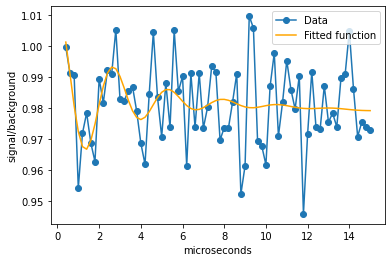

In [23]:
reconstructed_single_scan = recombine_scans(full_scans)
    
contrast = build_contrast(reconstructed_single_scan)
x_data = contrast[:, 0]*1e6
y_data = contrast[:, 1]


params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data,
                                              p0=[.005, 1, 1, 1, 1, 0], maxfev=50000)
#params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data, maxfev=5000)


plt.figure(figsize=(6, 4))
#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('microseconds')
plt.ylabel('signal/background')
plt.plot(x_data, rabi_oscillation(x_data, *params),
         label='Fitted function', color='orange')
plt.legend()

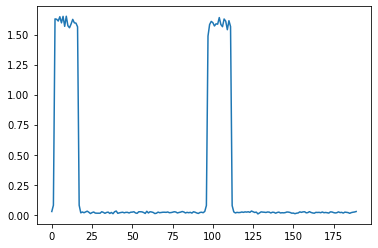

In [ ]:
plot_rolled_trace(reconstructed_single_scan[-1][-1])

In [18]:
reconstructed_single_scan

[[4e-07,
  44,
  array([0.019, 0.063, 1.426, 1.501, 1.502, 1.443, 1.528, 1.462, 1.497,
         1.467, 1.493, 1.513, 1.468, 1.448, 1.529, 1.466, 1.403, 0.067,
         0.02 , 0.025, 0.023, 0.015, 0.015, 0.066, 1.474, 1.469, 1.423,
         1.52 , 1.463, 1.534, 1.472, 1.478, 1.452, 1.465, 1.488, 1.475,
         1.494, 1.562, 1.431, 0.063, 0.028, 0.015, 0.023, 0.023])],
 [6e-07,
  46,
  array([0.014, 0.055, 1.439, 1.468, 1.505, 1.535, 1.461, 1.475, 1.554,
         1.541, 1.452, 1.551, 1.476, 1.528, 1.485, 1.469, 1.415, 0.091,
         0.025, 0.018, 0.023, 0.019, 0.022, 0.018, 0.052, 1.407, 1.498,
         1.496, 1.51 , 1.478, 1.464, 1.492, 1.507, 1.519, 1.512, 1.477,
         1.479, 1.513, 1.525, 1.524, 0.078, 0.016, 0.021, 0.017, 0.023,
         0.018])],
 [8e-07,
  48,
  array([0.016, 0.065, 1.429, 1.498, 1.456, 1.533, 1.427, 1.532, 1.477,
         1.495, 1.4  , 1.475, 1.565, 1.52 , 1.498, 1.49 , 1.526, 0.088,
         0.019, 0.017, 0.016, 0.017, 0.019, 0.014, 0.016, 0.053, 1.449,
    